In [3]:
#Import Dependencies
import pandas as pd
import numpy as np
import tensorflow

import seaborn as sn
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import LabelEncoder, MinMaxScaler , StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping


Using TensorFlow backend.


In [4]:
# Update sklearn to prevent version mismatches
!pip install sklearn --upgrade

Requirement already up-to-date: sklearn in /Users/igorpyanin/opt/anaconda3/envs/PythonData/lib/python3.7/site-packages (0.0)


In [5]:
# install joblib. This will be used to save your model. 
# Restart your kernel after installing 
!pip install joblib

   # KNN based on 5 bins

In [6]:
#this is your X
file = "data_cleaning/Output/cleaned_data_5_bin.csv"
df = pd.read_csv(file)
data = df.drop(["price", "price_bin"], axis=1)
feature_names = data.columns
data.head()

,zipcode,room_type,accommodates,bedrooms,bathrooms,beds,minimum_nights,number_of_reviews
0,94117,Entire home/apt,3,1.0,1.0,2.0,1,240
1,94110,Entire home/apt,5,2.0,1.0,3.0,30,111
2,94117,Private room,2,1.0,4.0,1.0,32,19
3,94117,Private room,2,1.0,4.0,1.0,32,8
4,94110,Private room,3,1.0,1.0,1.0,1,736


In [7]:
#this is your y.  Convert to strings, even though it's already an array of strings, otherwise model will choke.
target = df["price_bin"].map(lambda x:str(x))

df.groupby("price_bin").count().index
print(target.unique())

['bin 200-250' 'bin 0-100' 'bin 156-199' 'bin 101 -155' 'bin 251-500']


In [8]:
#code for multi-column label encoder from stack overlow:
#https://stackoverflow.com/questions/24458645/label-encoding-across-multiple-columns-in-scikit-learn

class MultiColumnLabelEncoder:
    def __init__(self,columns = None):
        self.columns = columns # array of column names to encode

    def fit(self,X,y=None):
        return self # not relevant here

    def transform(self,X):
        '''
        Transforms columns of X specified in self.columns using
        LabelEncoder(). If no columns specified, transforms all
        columns in X.
        '''
        output = X.copy()

        for col in self.columns:
            output[col] = LabelEncoder().fit_transform(output[col])

        return output

    def fit_transform(self,X,y=None):
        return self.fit(X,y).transform(X)


In [9]:
#LabelEncode room_type and zipcode.  No need to one-hot encode

data=MultiColumnLabelEncoder(columns = ['room_type', 'zipcode']).fit_transform(data)
data.head()

,zipcode,room_type,accommodates,bedrooms,bathrooms,beds,minimum_nights,number_of_reviews
0,14,0,3,1.0,1.0,2.0,1,240
1,8,0,5,2.0,1.0,3.0,30,111
2,14,1,2,1.0,4.0,1.0,32,19
3,14,1,2,1.0,4.0,1.0,32,8
4,8,1,3,1.0,1.0,1.0,1,736


In [10]:
data.groupby(['room_type', 'zipcode' ]).count()

accommodates  bedrooms  bathrooms  beds  minimum_nights  \
room_type zipcode                                                            
0         0                  15        15         15    15              15   
          1                 224       224        224   224             224   
          2                 288       288        288   288             288   
          3                   5         5          5     5               5   
          4                 131       131        131   131             131   
...                         ...       ...        ...   ...             ...   
2         17                  5         5          5     5               5   
          19                  2         2          2     2               2   
          23                  1         1          1     1               1   
          24                 38        38         38    38              38   
          26                  4         4          4     4               4   

                   number_of_reviews  
room_type zipcode                     
0         0                       15  
          1                      224  
          2                      288  
          3                        5  
          4                      131  
...                              ...  
2         17                       5  
          19                       2  
          23                       1  
          24                      38  
          26                       4  

[73 rows x 6 columns]

In [11]:
#Use price for the y values
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, target, random_state=42, test_size = .2)
 
y_train.dtypes

dtype('O')

In [12]:
#choose label encoder or one hot encode
#bins are already labels
2
#try each by themselves

label_encoder = LabelEncoder()
label_encoder.fit(y_train)
encoded_y_train = label_encoder.transform(y_train)
encoded_y_test = label_encoder.transform(y_test)

y_train_categorical = to_categorical(encoded_y_train)
y_test_categorical = to_categorical(encoded_y_test)

len(y_test_categorical[0])
y_test_categorical[0]
len(y_train_categorical[0])

5

In [13]:
# Scale your data

from sklearn.preprocessing import MinMaxScaler


X_minmax = MinMaxScaler().fit(X_train)

X_train_scaled_ = X_minmax.transform(X_train)
X_test_scaled_= X_minmax.transform(X_test)

X_train_scaled_
#X_train_scaled.shape

array([[2.30769231e-01, 5.00000000e-01, 6.66666667e-02, ...,
        7.14285714e-02, 1.00000001e-08, 6.09013398e-03],
       [7.69230769e-02, 5.00000000e-01, 0.00000000e+00, ...,
        7.14285714e-02, 9.00000009e-08, 2.24116931e-01],
       [5.00000000e-01, 5.00000000e-01, 6.66666667e-02, ...,
        0.00000000e+00, 0.00000000e+00, 1.09622412e-02],
       ...,
       [2.69230769e-01, 0.00000000e+00, 2.00000000e-01, ...,
        1.42857143e-01, 2.90000003e-07, 0.00000000e+00],
       [5.38461538e-01, 0.00000000e+00, 6.66666667e-02, ...,
        7.14285714e-02, 2.90000003e-07, 1.51035323e-01],
       [4.23076923e-01, 0.00000000e+00, 2.00000000e-01, ...,
        1.42857143e-01, 2.90000003e-07, 0.00000000e+00]])

In [14]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(X_train_scaled_, y_train)

/Users/igorpyanin/opt/anaconda3/envs/PythonData/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [15]:
rf.feature_importances_

array([0.2455738 , 0.0951341 , 0.07981714, 0.07755598, 0.06036521,
       0.06194384, 0.0555468 , 0.32406313])

In [16]:
data.columns

Index(['zipcode', 'room_type', 'accommodates', 'bedrooms', 'bathrooms', 'beds',
       'minimum_nights', 'number_of_reviews'],
      dtype='object')

#### Scale data using random forest feature importances

In [17]:
rf_feature_importances = [0.26654518, 0.05109481, 0.08917569, 0.05407983, 0.06835171,
       0.06496296, 0.05581106, 0.34997875]

In [18]:
X_train_scaled = X_train_scaled_ * rf_feature_importances
X_test_scaled= X_test_scaled_ * rf_feature_importances

In [19]:
#get number of feature columns.  This will be the input dimension for the model.
X_train_scaled.shape
#X_train_scaled.shape[1]

(6004, 8)

#### Compare 'manhattan' and 'euclidean' metric 

In [20]:

from sklearn.neighbors import KNeighborsClassifier
# Create KNN classifier
knn = KNeighborsClassifier(n_neighbors = 13, metric ='manhattan')
# Fit the classifier to the data
knn.fit(X_train_scaled,y_train)

#check accuracy of our model on the test data
knn.score(X_test_scaled, y_test)

0.4883411059293804

In [21]:
from sklearn.neighbors import KNeighborsClassifier
# Create KNN classifier
knn = KNeighborsClassifier(n_neighbors = 13, metric ='euclidean')
# Fit the classifier to the data
knn.fit(X_train_scaled,y_train)

#check accuracy of our model on the test data
knn.score(X_test_scaled, y_test)

0.4883411059293804

In [22]:
#show first 5 model predictions on the test data
knn.predict(X_test_scaled)[0:5]

array(['bin 156-199', 'bin 156-199', 'bin 0-100', 'bin 101 -155',
       'bin 251-500'], dtype=object)

#### Choose best k value

k: 1, Train/Test Score: 0.913/0.461
k: 3, Train/Test Score: 0.679/0.467
k: 5, Train/Test Score: 0.629/0.490
k: 7, Train/Test Score: 0.605/0.491
k: 9, Train/Test Score: 0.583/0.495
k: 11, Train/Test Score: 0.572/0.490
k: 13, Train/Test Score: 0.559/0.488
k: 15, Train/Test Score: 0.554/0.487
k: 17, Train/Test Score: 0.543/0.496
k: 19, Train/Test Score: 0.541/0.488
k: 21, Train/Test Score: 0.535/0.484
k: 23, Train/Test Score: 0.537/0.490
k: 25, Train/Test Score: 0.534/0.485
k: 27, Train/Test Score: 0.532/0.486
k: 29, Train/Test Score: 0.527/0.476


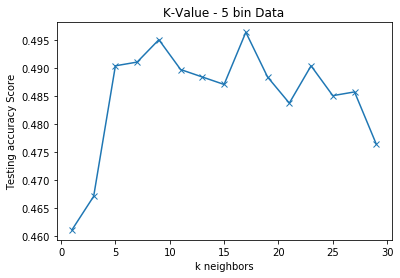

In [31]:
# Loop through different k values to see which has the highest accuracy
# Note: We only use odd numbers because we don't want any ties
train_scores = []
test_scores = []
for k in range(1, 30, 2):
    knn = KNeighborsClassifier(n_neighbors=k, metric='manhattan')
    knn.fit(X_train_scaled, y_train)
    train_score = knn.score(X_train_scaled, y_train)
    test_score = knn.score(X_test_scaled, y_test)
    train_scores.append(train_score)
    test_scores.append(test_score)
    print(f"k: {k}, Train/Test Score: {train_score:.3f}/{test_score:.3f}")
    
    
#plt.plot(range(1, 30, 2), train_scores, marker='o')
plt.plot(range(1, 30, 2), test_scores, marker="x")
plt.xlabel("k neighbors")
plt.ylabel("Testing accuracy Score")
plt.title("K-Value - 5 bin Data")
plt.savefig("data_cleaning/Graphs/k_value_5-bin.png")
plt.show()

### Grid seach doesn't work because we don't use scaling for data2

In [24]:
from sklearn.model_selection import GridSearchCV
#create new a knn model
knn2 = KNeighborsClassifier()
#create a dictionary of all values we want to test for n_neighbors
param_grid = {'n_neighbors': np.arange(1, 25, 2).tolist(), 'metric': ['euclidean', 'manhattan']}
#use gridsearch to test all values for n_neighbors
knn_gscv = GridSearchCV(knn2, param_grid, cv=5)
#fit model to data
knn_gscv.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='warn', n_jobs=None,
             param_grid={'metric': ['euclidean', 'manhattan'],
                         'n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21,
                                         23]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [25]:
#check top performing n_neighbors value
knn_gscv.best_params_

{'metric': 'manhattan', 'n_neighbors': 23}

In [26]:
#check mean score for the top performing value of n_neighbors
knn_gscv.best_score_

0.48384410393071287

In [30]:
# Note that k: 17 seems to be the best choice for this dataset
knn = KNeighborsClassifier(n_neighbors=17, metric='manhattan')
knn.fit(X_train_scaled, y_train)
print('k=17 Test Acc: %.3f' % knn.score(X_test_scaled, y_test))

k=17 Test Acc: 0.496


In [32]:
import joblib

filename = "modelKNN5.sav"

joblib.dump(rf, filename)

['modelKNN5.sav']